#tools using router concept in langgraph

In [51]:
from langchain_groq import ChatGroq
from langgraph.graph import START,StateGraph,END
from typing import Annotated
from typing import TypedDict
from IPython.display import display,Image
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode,tools_condition
from langchain.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [52]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [53]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [54]:
llm=ChatGroq(model="gemma2-9b-it")

In [55]:
llm.invoke("what is gen ai")

AIMessage(content="##  Gen AI: The Creative Powerhouse\n\nGen AI, short for **Generative Artificial Intelligence**, is a type of AI that focuses on **creating new content**. \n\nThink of it as an AI artist, writer, composer, or even programmer. Instead of analyzing existing data, Gen AI learns patterns and structures from massive datasets and uses that knowledge to generate something entirely new:\n\n* **Text:** Writing stories, poems, articles, code, scripts, and more.\n* **Images:** Creating paintings, photos, illustrations, logos, and even 3D models.\n* **Audio:** Composing music, generating sound effects, and even mimicking voices.\n* **Video:** Synthesizing video clips, animating characters, and generating special effects.\n\n**How does it work?**\n\nGen AI models, often based on **deep learning** techniques like **transformer networks**, are trained on vast amounts of data. This training allows them to understand the underlying patterns and relationships within the data. \n\nWhen

In [56]:
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [57]:
search=TavilySearchResults()

In [58]:
search.invoke("which team won the 2011 cricket world cup and captain name")

[{'url': 'https://www.sportskeeda.com/cricket/world-cup-2011-captains-where-are-they-now',
  'content': 'He is a part of the Peshawar Zalmi in PSL, Jamaica Tallawahs in the CPL, Dhaka Dynamites in the BPL and recently was also a part of the ICC World XI.\n#10 Graeme Smith (South Africa)\nGraeme Smith had been one of the best captains of South Africa. After the 2015 World Cup, Andrew Strauss was appointed as the director of the England and Wales Cricket Board to bring more transparency in the board and to remove any restrictions which the England Cricket Team would face in the future.\n Darren Sammy was the leader of the Windies in World Cup 2011 and had helped the team in reaching quarterfinals of the tournament before losing to Pakistan to crash out of the tournament.\n The Right-handed batsmen now have taken the task to promote younger cricketers as he was the part of coaching staff of the Mumbai Indians in 2015-16 and of the Delhi Daredevils (now Delhi Capitals) since 2018.\n Jimmy 

In [59]:
@tool
def multiply(first_number:int,second_number:int)->int:
    """perform multiply operation"""
    return first_number * second_number

In [60]:
multiply.invoke({"first_number":20,"second_number":30})

600

In [61]:
tools=[multiply,search]

In [62]:
model_with_bind=llm.bind_tools(tools=tools)

In [63]:
tool_node=ToolNode(tools=tools)

In [64]:
class AgentState(TypedDict):
    messages:Annotated[list,add_messages]

In [65]:
def function_1(state:AgentState):
    print("==> entering into the llm <==")
    response=model_with_bind.invoke(state["messages"])
    return {"messages":[response]}


In [66]:
response=function_1({"messages":["what is the multiplication 2* 3"]})

==> entering into the llm <==


In [67]:
messages=response['messages']

In [68]:
last_message=messages[-1]

In [69]:
#last_message.tool_calls

In [70]:
def router(state:AgentState):
    print("entering into router")
    messages=state["messages"]
    last_message=messages[-1]
    print(f"the  last message {last_message}")
    if last_message.tool_calls:
        return 'TOOLS'
    return END


In [71]:
graph=StateGraph(AgentState)

In [72]:
graph.add_node("llm",function_1)
graph.add_node("tools",tool_node)
graph.set_entry_point("llm")

graph.add_conditional_edges(
    "llm",
    router,
    {
        "TOOLS":"tools",
        END:END
    }
)

graph.add_edge("tools",END)

In [73]:
app=graph.compile()

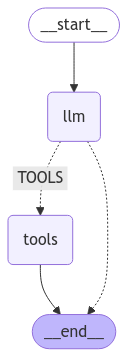

In [74]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except  Exception as e:
    print(e)

In [75]:
app.invoke({"messages":["what is multiplication of 20 and 30"]})

==> entering into the llm <==
entering into router
the  last message content='' additional_kwargs={'tool_calls': [{'id': 'call_asr9', 'function': {'arguments': '{"first_number":20,"second_number":30}', 'name': 'multiply'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1120, 'total_tokens': 1212, 'completion_time': 0.167272727, 'prompt_time': 0.03571815, 'queue_time': 0.023512864, 'total_time': 0.202990877}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-39df1c54-157c-4a3d-acbd-79065a85e167-0' tool_calls=[{'name': 'multiply', 'args': {'first_number': 20, 'second_number': 30}, 'id': 'call_asr9', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1120, 'output_tokens': 92, 'total_tokens': 1212}


{'messages': [HumanMessage(content='what is multiplication of 20 and 30', additional_kwargs={}, response_metadata={}, id='f4e488ff-2940-4c28-8d95-9988e80e7290'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_asr9', 'function': {'arguments': '{"first_number":20,"second_number":30}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1120, 'total_tokens': 1212, 'completion_time': 0.167272727, 'prompt_time': 0.03571815, 'queue_time': 0.023512864, 'total_time': 0.202990877}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-39df1c54-157c-4a3d-acbd-79065a85e167-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 20, 'second_number': 30}, 'id': 'call_asr9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1120, 'output_tokens': 92, 'total_tokens': 1212}),
  ToolMessage(content='600', name='multiply', id='10

In [77]:
app.invoke({"messages":["what is gen ai"]})

==> entering into the llm <==
entering into router
the  last message content='' additional_kwargs={'tool_calls': [{'id': 'call_q3tv', 'function': {'arguments': '{"query":"what is gen ai"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 1113, 'total_tokens': 1202, 'completion_time': 0.161818182, 'prompt_time': 0.035578043, 'queue_time': 0.021173313000000006, 'total_time': 0.197396225}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-4c07e99a-b94a-4e3c-8c8b-46be569beb7a-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'what is gen ai'}, 'id': 'call_q3tv', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1113, 'output_tokens': 89, 'total_tokens': 1202}


{'messages': [HumanMessage(content='what is gen ai', additional_kwargs={}, response_metadata={}, id='f0146151-7396-426c-879d-20eb6038c727'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_q3tv', 'function': {'arguments': '{"query":"what is gen ai"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 1113, 'total_tokens': 1202, 'completion_time': 0.161818182, 'prompt_time': 0.035578043, 'queue_time': 0.021173313000000006, 'total_time': 0.197396225}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4c07e99a-b94a-4e3c-8c8b-46be569beb7a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'what is gen ai'}, 'id': 'call_q3tv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1113, 'output_tokens': 89, 'total_tokens': 1202}),
  ToolMessage(content='[{"url": "https://www.geeksfor

In [78]:
app.invoke({"messages":["what is the multiplication os 28 and 7"]})

==> entering into the llm <==
entering into router
the  last message content='' additional_kwargs={'tool_calls': [{'id': 'call_0vr6', 'function': {'arguments': '{"first_number":28,"second_number":7}', 'name': 'multiply'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1120, 'total_tokens': 1212, 'completion_time': 0.167272727, 'prompt_time': 0.04228971, 'queue_time': 0.022285229999999996, 'total_time': 0.209562437}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-5069ad63-802c-4e8e-8083-5a9155592f8e-0' tool_calls=[{'name': 'multiply', 'args': {'first_number': 28, 'second_number': 7}, 'id': 'call_0vr6', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1120, 'output_tokens': 92, 'total_tokens': 1212}


{'messages': [HumanMessage(content='what is the multiplication os 28 and 7', additional_kwargs={}, response_metadata={}, id='14a1ecbd-9343-435f-9b7e-57f3cd6cf078'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0vr6', 'function': {'arguments': '{"first_number":28,"second_number":7}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1120, 'total_tokens': 1212, 'completion_time': 0.167272727, 'prompt_time': 0.04228971, 'queue_time': 0.022285229999999996, 'total_time': 0.209562437}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5069ad63-802c-4e8e-8083-5a9155592f8e-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 28, 'second_number': 7}, 'id': 'call_0vr6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1120, 'output_tokens': 92, 'total_tokens': 1212}),
  ToolMessage(content='196', name='multipl